# Additional Improvements to ANN

## Import Relevant Libraries

In [1]:
# Basic
import random
import numpy as np
import pandas as pd

# Data Operations
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Data Visualisation
import matplotlib.pyplot as plt

# Hyperparameter Optimisation
from itertools import product

# Artificial Neural Network
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input
from keras.models import Sequential

# Model Evaluation
from sklearn.metrics import r2_score

## Global Params

In [2]:
SEED = 1212
DEVICE = "/GPU:0"

## Import Data

In [3]:
# Import Data
df = pd.read_csv("data/sanitized_basic.csv")
df = df[['DIVISION_CODE', 'COUNCIL_AREA_CODE', 'GROUP', 'INVESTIGATION_DURATION']]
df

,DIVISION_CODE,COUNCIL_AREA_CODE,GROUP,INVESTIGATION_DURATION
0,1,Aberdeen City,1.0,0
1,1,Aberdeen City,1.0,0
2,1,Aberdeen City,1.0,1
3,1,Aberdeenshire,3.0,0
4,1,Aberdeen City,3.0,0
...,...,...,...,...
2798123,3,Highland,7.0,1
2798124,3,Highland,7.0,1
2798125,3,Highland,7.0,0
2798126,3,Highland,7.0,0


## Data Preparation

In [4]:
# Split Target and Features
x = df.drop("INVESTIGATION_DURATION", axis=1)
y = df["INVESTIGATION_DURATION"]

In [5]:
# Encode Categorical Variables
encoder = ce.BinaryEncoder(cols=['DIVISION_CODE', 'COUNCIL_AREA_CODE', 'GROUP'])
x = encoder.fit_transform(x)

In [6]:
# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=SEED)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle=True, random_state=SEED)

## Helper Functions (For Visualisation)

In [7]:
def fit_scatter(y_true, y_pred):
    """Produces Fit Scatter Graph.
    Plots Measured Value Against Predicted Value.
    Only Shows Every 10th Point"""
    y_pred = y_pred.reshape(y_true.shape)
    plt.scatter(y_true[::10], y_pred[::10])
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')

In [8]:
def plot_learning(model_history):
    """Plots learning curve of Keras Model from History"""
    history_dict = model_history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    plt.plot(loss_values, 'b', label='Training')
    plt.plot(val_loss_values, 'r', label='Validation')
    plt.legend(loc="upper right")
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')

## Model Optimisation

In [29]:
def build_model(input_shape, n_layers, n_nodes, lr):
    """Takes input shape, layer dimensions and learning rate.
        Returns compiled model."""

    # Create Model
    mod = Sequential()

    # Input Layer
    mod.add(Input(shape=input_shape))

    # Hidden Layers
    for layer in range(n_layers):
        mod.add(Dense(n_nodes, activation='relu'))

    # Output Layer
    mod.add(Dense(1, activation='linear'))

    # Loss Function
    loss_func = keras.losses.MeanSquaredError()

    # Compile Model
    mod.compile(optimizer=keras.optimizers.SGD(learning_rate=lr), loss=loss_func)

    return mod

In [30]:
def train_model(mod, feat, targ, val_feat, val_targ, batch):
    """Takes a model, training data, validation data and batch size.
        Returns Fitted Model
    """

    with tf.device(DEVICE):

        # Early Stopping Callback
        early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1, verbose=0, restore_best_weights=True)

        # Train Model
        hist = mod.fit(feat, targ,
                       epochs=100,
                       batch_size=batch,
                       callbacks=early,
                       validation_data=(val_feat, val_targ),
                       shuffle=True)

        # Return Model and Learning Curve
        return mod, hist

In [28]:
# Parameter Ranges
hidden_layers = list(np.arange(2, 7, 1))
nodes = list(np.arange(10, 128, 2))
learning_rate = [1e-6, 1e-7]
batch_size = (128, 256, 512, 1024)

In [29]:
# All Combinations of Parameters
combs = list(product(hidden_layers, nodes, learning_rate, batch_size))

In [30]:
# Random Sample from Combinations
random.seed(SEED)
sample = random.sample(combs, 10)
sample

[(4, 80, 1e-07, 128),
 (4, 68, 1e-07, 128),
 (5, 68, 1e-06, 1024),
 (3, 46, 1e-07, 256),
 (6, 62, 1e-07, 512),
 (6, 92, 1e-06, 128),
 (3, 36, 1e-06, 256),
 (4, 110, 1e-06, 1024),
 (5, 90, 1e-07, 1024),
 (4, 62, 1e-06, 256)]

In [31]:
# Conduct Trials

# Set Best Validation Loss to High Number
best_validation = 1e20
best_config_ann = None

# Try Each Random Configuration
for comb in sample:

    # Print Model Configuration
    print("--- Training Model ---")
    print("Hidden Layers: ", comb[0], " Nodes Per Layer: ", comb[1], " Learning Rate: ", comb[2], " Batch Size: ", comb[3])

    # Show Model
    model = build_model(x_train.shape[1], comb[0], comb[1], comb[2])
    model, history = train_model(model, x_train, y_train, x_val, y_val, comb[3])

    # Get Validation Score
    val_score = model.evaluate(x_val, y_val)

    # Replace if Best
    if val_score < best_validation:
        best_validation = val_score
        best_config_ann = comb
    else:
        if best_config_ann is None:
            best_config_ann = comb

    print("Best Weights Validation Score: ", val_score)
    print("Best Validation Score: ", best_validation)
    print("Best Config: ", best_config_ann)

--- Training Model ---
Hidden Layers:  4  Nodes Per Layer:  80  Learning Rate:  1e-07  Batch Size:  128
Epoch 1/100
13117/13117 [==============================] - 26s 2ms/step - loss: 10534.0820 - val_loss: 10648.3945
Epoch 2/100
13117/13117 [==============================] - 25s 2ms/step - loss: 10528.5645 - val_loss: 10642.9297
Epoch 3/100
13117/13117 [==============================] - 26s 2ms/step - loss: 10523.0342 - val_loss: 10637.2393
Epoch 4/100
13117/13117 [==============================] - 25s 2ms/step - loss: 10516.9580 - val_loss: 10630.7246
Epoch 5/100
13117/13117 [==============================] - 26s 2ms/step - loss: 10509.9219 - val_loss: 10623.1084
Epoch 6/100
13117/13117 [==============================] - 26s 2ms/step - loss: 10501.4668 - val_loss: 10613.6289
Epoch 7/100
13117/13117 [==============================] - 26s 2ms/step - loss: 10490.6514 - val_loss: 10601.1045
Epoch 8/100
13117/13117 [==============================] - 26s 2ms/step - loss: 10475.7305 - val_l

In [32]:
# Get Best Parameters
best_config_ann

(4, 62, 1e-06, 256)

## Model Evaluation

### Best SGD Model

In [32]:
# Retrain Best Model
sgd = build_model(x_train.shape[1], 4, 62, 1e-6)
sgd, history = train_model(sgd, x_train, y_train, x_val, y_val, 256)

Epoch 1/100
6155/6155 [==============================] - 15s 2ms/step - loss: 10456.3203 - val_loss: 11624.7910
Epoch 2/100
6155/6155 [==============================] - 14s 2ms/step - loss: 10430.4697 - val_loss: 11589.9072
Epoch 3/100
6155/6155 [==============================] - 14s 2ms/step - loss: 10386.1895 - val_loss: 11534.5898
Epoch 4/100
6155/6155 [==============================] - 16s 3ms/step - loss: 10324.2852 - val_loss: 11464.4062
Epoch 5/100
6155/6155 [==============================] - 17s 3ms/step - loss: 10255.1992 - val_loss: 11396.0469
Epoch 6/100
6155/6155 [==============================] - 17s 3ms/step - loss: 10200.6211 - val_loss: 11353.8135
Epoch 7/100
6155/6155 [==============================] - 17s 3ms/step - loss: 10175.1064 - val_loss: 11338.2168
Epoch 8/100
6155/6155 [==============================] - 17s 3ms/step - loss: 10166.2568 - val_loss: 11331.6680
Epoch 9/100
6155/6155 [==============================] - 17s 3ms/step - loss: 10161.2354 - val_loss: 113

In [33]:
# Get Training and Test Scores
pred_train = sgd.predict(x_train)
pred_test = sgd.predict(x_test)

print("Train R2 Score: ", r2_score(y_train, pred_train))
print("Test R2 Score: ", r2_score(y_test, pred_test))

Train R2 Score:  0.02411167637384315
Test R2 Score:  0.023955695057702675


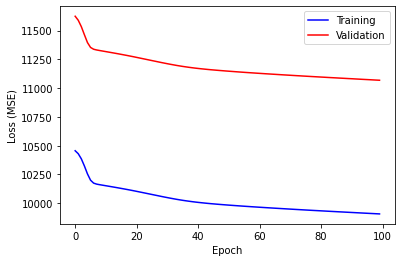

In [34]:
# Get Learning Curve
plot_learning(history)
plt.savefig('images/additional/reg_sgd_learn.pdf')
plt.show()

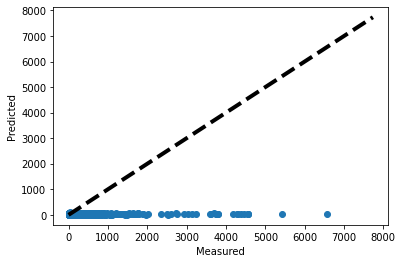

In [35]:
# Get Fit Scatter
fit_scatter(y_test, pred_test)
plt.savefig('images/additional/reg_sgd_fit.pdf')
plt.show()

### Try Adding Complexity

In [36]:
# Additional Model
comp = build_model(x_train.shape[1], 16, 128, 1e-6)
comp, history = train_model(comp, x_train, y_train, x_val, y_val, 256)

6155/6155 [==============================] - 30s 5ms/step - loss: 8869.5928 - val_loss: 10714.6934
Epoch 61/100
6155/6155 [==============================] - 29s 5ms/step - loss: 8820.8105 - val_loss: 10785.8262
Epoch 62/100
6155/6155 [==============================] - 29s 5ms/step - loss: 8862.9990 - val_loss: 10482.9619
Epoch 63/100
6155/6155 [==============================] - 29s 5ms/step - loss: 8850.6768 - val_loss: 10841.8965
Epoch 64/100
6155/6155 [==============================] - 29s 5ms/step - loss: 8876.8916 - val_loss: 10498.1777
Epoch 65/100
6155/6155 [==============================] - 29s 5ms/step - loss: 8854.1748 - val_loss: 10682.2725
Epoch 66/100
6155/6155 [==============================] - 29s 5ms/step - loss: 8900.6143 - val_loss: 10585.6016
Epoch 67/100
6155/6155 [==============================] - 29s 5ms/step - loss: 8842.5010 - val_loss: 10937.1221
Epoch 68/100
6155/6155 [==============================] - 32s 5ms/step - loss: 8832.5947 - val_loss: 10618.1104
Epoch

In [37]:
# Get Training and Test Scores
pred_train = comp.predict(x_train)
pred_test = comp.predict(x_test)

print("Train R2 Score: ", r2_score(y_train, pred_train))
print("Test R2 Score: ", r2_score(y_test, pred_test))

Train R2 Score:  0.05062116922941462
Test R2 Score:  0.043739389536355255


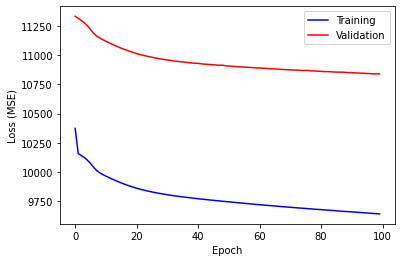

In [38]:
# Get Learning Curve
plot_learning(history)
plt.savefig('images/additional/reg_comp_learn.pdf')
plt.show()

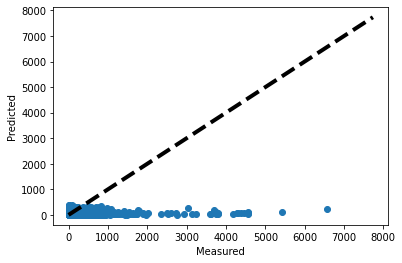

In [39]:
# Get Fit Scatter
fit_scatter(y_test, pred_test)
plt.savefig('images/additional/reg_comp_fit.pdf')
plt.show()

### Try Using All Features

In [40]:
# Import Data
df = pd.read_csv("data/sanitized_additional.csv")
df = df[['DIVISION_CODE', 'COUNCIL_AREA_CODE', 'GROUP', 'STATS_CLASS_CODE', 'BEAT', 'OCCUR_RANGE', 'REPORT_DELAY', 'INVESTIGATION_DURATION']]
df

,DIVISION_CODE,COUNCIL_AREA_CODE,GROUP,STATS_CLASS_CODE,BEAT,OCCUR_RANGE,REPORT_DELAY,INVESTIGATION_DURATION
0,1,Aberdeen City,1.0,Serious Assault,AS2B,0,0,0
1,1,Aberdeen City,1.0,Serious Assault,AN3B,0,0,0
2,1,Aberdeen City,1.0,Serious Assault,AN7A,0,0,1
3,1,Aberdeenshire,3.0,Housebreaking with intent to steal - other pro...,S1A,0,0,0
4,1,Aberdeen City,3.0,Theft of motor vehicle & contents incl. taking...,AN3A,0,0,0
...,...,...,...,...,...,...,...,...
2625959,10,South Lanarkshire,7.0,Seat Belt Offences,QC55,0,0,0
2625960,5,City of Edinburgh,7.0,"Motor Vehicles, Other Offences",SE41,0,1,0
2625961,1,Aberdeen City,7.0,"Motor Vehicles, Other Offences",AN6C,0,50,2
2625962,5,City of Edinburgh,7.0,"Motor Vehicles, Other Offences",NW29,0,1,0


In [41]:
# Split Target and Features
x = df.drop("INVESTIGATION_DURATION", axis=1)
y = df["INVESTIGATION_DURATION"]

In [42]:
# Encode Categorical Variables
encoder = ce.BinaryEncoder(cols=['DIVISION_CODE', 'COUNCIL_AREA_CODE', 'GROUP', 'STATS_CLASS_CODE', 'BEAT'])
x = encoder.fit_transform(x)

In [43]:
# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=SEED)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle=True,
                                                      random_state=SEED)

In [44]:
# Scale Continuous
scaler = MinMaxScaler()
scaler.fit(np.array(x_train['OCCUR_RANGE']).reshape(-1, 1))

x_train['OCCUR_RANGE'] = scaler.transform(np.array(x_train['OCCUR_RANGE']).reshape(-1, 1))
x_test['OCCUR_RANGE'] = scaler.transform(np.array(x_test['OCCUR_RANGE']).reshape(-1, 1))
x_val['OCCUR_RANGE'] = scaler.transform(np.array(x_val['OCCUR_RANGE']).reshape(-1, 1))

scaler = MinMaxScaler()
scaler.fit(np.array(x_train['REPORT_DELAY']).reshape(-1, 1))
x_train['REPORT_DELAY'] = scaler.transform(np.array(x_train['REPORT_DELAY']).reshape(-1, 1))
x_test['REPORT_DELAY'] = scaler.transform(np.array(x_test['REPORT_DELAY']).reshape(-1, 1))
x_val['REPORT_DELAY'] = scaler.transform(np.array(x_val['REPORT_DELAY']).reshape(-1, 1))

In [45]:
# Retrain Best Model
all_feat = build_model(x_train.shape[1], 16, 128, 1e-6)
all_feat, history = train_model(all_feat, x_train, y_train, x_val, y_val, 256)

Epoch 1/100
6155/6155 [==============================] - 28s 4ms/step - loss: 10365.6211 - val_loss: 11338.8848
Epoch 2/100
6155/6155 [==============================] - 28s 4ms/step - loss: 10159.6982 - val_loss: 11317.2012
Epoch 3/100
6155/6155 [==============================] - 29s 5ms/step - loss: 10140.1875 - val_loss: 11296.0215
Epoch 4/100
6155/6155 [==============================] - 29s 5ms/step - loss: 10118.0312 - val_loss: 11270.2393
Epoch 5/100
6155/6155 [==============================] - 29s 5ms/step - loss: 10089.6367 - val_loss: 11236.6973
Epoch 6/100
6155/6155 [==============================] - 29s 5ms/step - loss: 10051.5420 - val_loss: 11191.9238
Epoch 7/100
6155/6155 [==============================] - 29s 5ms/step - loss: 10010.7285 - val_loss: 11156.0059
Epoch 8/100
6155/6155 [==============================] - 29s 5ms/step - loss: 9984.5762 - val_loss: 11136.2588
Epoch 9/100
6155/6155 [==============================] - 30s 5ms/step - loss: 9969.4561 - val_loss: 11124

In [46]:
# Get Training and Test Scores
pred_train = all_feat.predict(x_train)
pred_test = all_feat.predict(x_test)

print("Train R2 Score: ", r2_score(y_train, pred_train))
print("Test R2 Score: ", r2_score(y_test, pred_test))

Train R2 Score:  0.051652830340198075
Test R2 Score:  0.04520632216073761


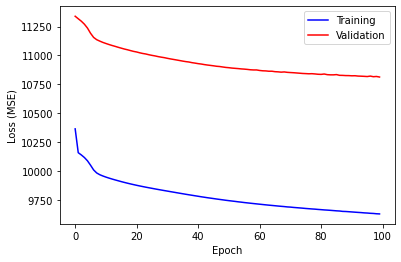

In [47]:
# Get Learning Curve
plot_learning(history)
plt.savefig('images/additional/reg_all_learn.pdf')
plt.show()

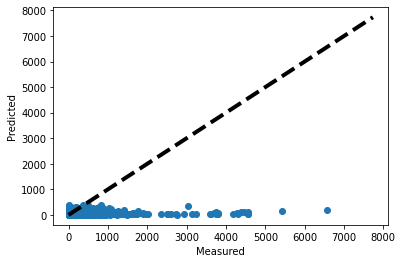

In [48]:
# Get Fit Scatter
fit_scatter(y_test, pred_test)
plt.savefig('images/additional/reg_all_fit.pdf')
plt.show()

### Try Truncating Target Variable

In [49]:
df = df[df['INVESTIGATION_DURATION'] <= 365]

In [50]:
# Split Target and Features
x = df.drop("INVESTIGATION_DURATION", axis=1)
y = df["INVESTIGATION_DURATION"]

In [51]:
# Encode Categorical Variables
encoder = ce.BinaryEncoder(cols=['DIVISION_CODE', 'COUNCIL_AREA_CODE', 'GROUP', 'STATS_CLASS_CODE', 'BEAT'])
x = encoder.fit_transform(x)

In [52]:
# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=SEED)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle=True,
                                                      random_state=SEED)

In [53]:
# Scale Continuous
scaler = MinMaxScaler()
scaler.fit(np.array(x_train['OCCUR_RANGE']).reshape(-1, 1))

x_train['OCCUR_RANGE'] = scaler.transform(np.array(x_train['OCCUR_RANGE']).reshape(-1, 1))
x_test['OCCUR_RANGE'] = scaler.transform(np.array(x_test['OCCUR_RANGE']).reshape(-1, 1))
x_val['OCCUR_RANGE'] = scaler.transform(np.array(x_val['OCCUR_RANGE']).reshape(-1, 1))

scaler = MinMaxScaler()
scaler.fit(np.array(x_train['REPORT_DELAY']).reshape(-1, 1))
x_train['REPORT_DELAY'] = scaler.transform(np.array(x_train['REPORT_DELAY']).reshape(-1, 1))
x_test['REPORT_DELAY'] = scaler.transform(np.array(x_test['REPORT_DELAY']).reshape(-1, 1))
x_val['REPORT_DELAY'] = scaler.transform(np.array(x_val['REPORT_DELAY']).reshape(-1, 1))

In [54]:
# Retrain Best Model
trunc = build_model(x_train.shape[1], 16, 128, 1e-6)
trunc, history = train_model(trunc, x_train, y_train, x_val, y_val, 256)

Epoch 1/100
6115/6115 [==============================] - 26s 4ms/step - loss: 1717.3457 - val_loss: 1629.4412
Epoch 2/100
6115/6115 [==============================] - 27s 4ms/step - loss: 1634.4376 - val_loss: 1615.3804
Epoch 3/100
6115/6115 [==============================] - 29s 5ms/step - loss: 1617.1875 - val_loss: 1594.2384
Epoch 4/100
6115/6115 [==============================] - 29s 5ms/step - loss: 1592.6886 - val_loss: 1568.6525
Epoch 5/100
6115/6115 [==============================] - 29s 5ms/step - loss: 1572.1750 - val_loss: 1554.4816
Epoch 6/100
6115/6115 [==============================] - 29s 5ms/step - loss: 1561.4685 - val_loss: 1546.3668
Epoch 7/100
6115/6115 [==============================] - 29s 5ms/step - loss: 1553.9083 - val_loss: 1539.7743
Epoch 8/100
6115/6115 [==============================] - 29s 5ms/step - loss: 1547.7610 - val_loss: 1534.3065
Epoch 9/100
6115/6115 [==============================] - 29s 5ms/step - loss: 1542.3623 - val_loss: 1529.4469
Epoch 10/1

In [55]:
# Get Training and Test Scores
pred_train = trunc.predict(x_train)
pred_test = trunc.predict(x_test)

print("Train R2 Score: ", r2_score(y_train, pred_train))
print("Test R2 Score: ", r2_score(y_test, pred_test))

Train R2 Score:  0.11962413076287026
Test R2 Score:  0.11424732391109715


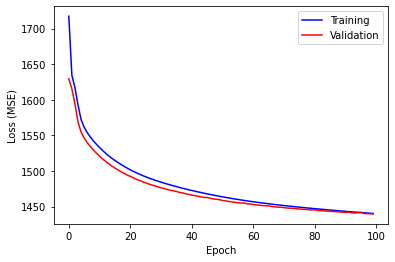

In [56]:
# Get Learning Curve
plot_learning(history)
plt.savefig('images/additional/reg_trunc_learn.pdf')
plt.show()

In [ ]:
# Get Fit Scatter
fit_scatter(y_test, pred_test)
plt.savefig('images/additional/reg_trunc_fit.pdf')
plt.show()